<a href="https://colab.research.google.com/github/Ljuhyeon/Ljuhyeon.github.io/blob/master/movie_recommand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

- budget: The budget in which the movie was made.
- genre:  The genre of the movie, Action, comedy, Thriller etc.
- homepage: A link to the homepage of the movie.
- id:This is infact the movie_id as in the first dataset.
- keywords:The keywords or tags related to the movie.
- original_language: The language in which the movie was made.
- original_title: The title of the movie before translation or adaptation.
- overview:  A brief description of the movie.
- popularity: A numeric quantity specifying the movie popularity.
- production_companies: The production house of the movie.
- production_countries: The country in which it was produced.
- release_date:The date on which it was released.
- revenue: The worldwide revenue generated by the movie.
- runtime: The running time of the movie in minutes.
- status:Released or Rumored
- tagline: Movie's tagline.
- title: Title of the movie.
- vote_average: average ratings the movie recieved.
- vote_count: the count of votes recieved.


In [ ]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

DATA_PATH = "/content/data/MyDrive/encoreplaydata/DeepLearning/recommendation/data/Movie/ml-1m/"

Mounted at /content/data


In [ ]:
movies = pd.read_csv(DATA_PATH+"movies_metadata.csv")
ratings = pd.read_csv(DATA_PATH+"ratings.csv")
print(f'{movies.shape}')
print(f'{ratings.shape}')

(45466, 24)
(100004, 4)


In [ ]:
movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [ ]:
movies['original_title']

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
45461                        رگ خواب
45462            Siglo ng Pagluluwal
45463                       Betrayal
45464            Satana likuyushchiy
45465                       Queerama
Name: original_title, Length: 45466, dtype: object

In [ ]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [ ]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
movies.info(),  ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

(None, None)

# 간단한 전처리

movies 데이터셋에서 필요한 컬럼만 추출

In [ ]:
movies_df = movies[['id', 'genres', 'original_title','vote_average', 'vote_count','popularity']].copy()
movies_df.head()

,id,genres,original_title,vote_average,vote_count,popularity
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,7.7,5415.0,21.946943
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,6.9,2413.0,17.015539
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,6.5,92.0,11.7129
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,6.1,34.0,3.859495
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,5.7,173.0,8.387519


`id`, `movieId`를 기준으로 정렬

In [ ]:
movies_df = movies_df.sort_values(by='id', ascending=True).reset_index()
movies_df.head()

,index,id,genres,original_title,vote_average,vote_count,popularity
0,2429,100,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...","Lock, Stock and Two Smoking Barrels",7.5,1671.0,4.60786
1,13609,10000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",La estrategia del caracol,7.2,9.0,0.281609
2,4435,10001,"[{'id': 35, 'name': 'Comedy'}, {'id': 878, 'na...",Young Einstein,4.5,46.0,2.562888
3,17451,100010,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",Flight Command,6.0,1.0,0.769266
4,36946,100017,"[{'id': 18, 'name': 'Drama'}]",Verfolgt,4.8,7.0,2.964103


In [ ]:
ratings_df = ratings.sort_values(by='movieId', ascending=True).reset_index()
ratings_df.head()

,index,userId,movieId,rating,timestamp
0,9713,68,1,4.0,1194741818
1,35933,261,1,1.5,1101665532
2,52631,383,1,5.0,852806429
3,35983,262,1,2.5,1433898798
4,12038,77,1,4.0,1163005363


결측치 확인

In [ ]:
(movies_df.isnull().sum() / movies_df.shape[0]).round(4).sort_values(ascending=False)

vote_average      0.0001
vote_count        0.0001
popularity        0.0001
index             0.0000
id                0.0000
genres            0.0000
original_title    0.0000
dtype: float64

In [ ]:
(ratings_df.isnull().sum() / ratings_df.shape[0]).round(4).sort_values(ascending=False)

index        0.0
userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64

결측치 제거

In [ ]:
movies_df = movies_df.dropna()

(movies_df.isnull().sum() / movies_df.shape[0]).round(4).sort_values(ascending=False)

index             0.0
id                0.0
genres            0.0
original_title    0.0
vote_average      0.0
vote_count        0.0
popularity        0.0
dtype: float64

### 데이터프레임 join

In [ ]:
# join 해주기위해 id를 movieId로 컬럼명 변경
movies_df = movies_df.rename(columns={'id':'movieId'})

# movie의 경우 int 타입으로 되어있고, meta의 경우 object타입으로 되어있음
# 그래서 join을 하기위해 형변환 필수
movies_df['movieId'] = movies_df['movieId'].astype(str)
ratings_df['movieId'] = ratings_df['movieId'].astype(str)

# 왼쪽 데이터와 movieId를 기준으로 두 데이터를 병합시킨다.
movie_df = pd.merge(ratings_df, movies_df, how='left', on='movieId')

movie_df.head()

,index_x,userId,movieId,rating,timestamp,index_y,genres,original_title,vote_average,vote_count,popularity
0,9713,68,1,4.0,1194741818,NaN,NaN,NaN,NaN,NaN,NaN
1,35933,261,1,1.5,1101665532,NaN,NaN,NaN,NaN,NaN,NaN
2,52631,383,1,5.0,852806429,NaN,NaN,NaN,NaN,NaN,NaN
3,35983,262,1,2.5,1433898798,NaN,NaN,NaN,NaN,NaN,NaN
4,12038,77,1,4.0,1163005363,NaN,NaN,NaN,NaN,NaN,NaN


불필요한 컬럼 제거

In [ ]:
movie_df = movie_df.drop(movie_df[['index_x', 'index_y', 'timestamp']], axis=1)

In [ ]:
movie_df.head()

,userId,movieId,rating,genres,original_title,vote_average,vote_count,popularity
0,68,1,4.0,NaN,NaN,NaN,NaN,NaN
1,261,1,1.5,NaN,NaN,NaN,NaN,NaN
2,383,1,5.0,NaN,NaN,NaN,NaN,NaN
3,262,1,2.5,NaN,NaN,NaN,NaN,NaN
4,77,1,4.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100009 entries, 0 to 100008
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userId          100009 non-null  int64  
 1   movieId         100009 non-null  object 
 2   rating          100009 non-null  float64
 3   genres          44994 non-null   object 
 4   original_title  44994 non-null   object 
 5   vote_average    44994 non-null   float64
 6   vote_count      44994 non-null   float64
 7   popularity      44994 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 6.9+ MB


### 결측치 처리

`genres`, `original_title` 데이터가 있어야 추천이 가능하므로 해당 컬럼의 결측치의 경우 제거해줘야한다.

In [ ]:
(movie_df.isnull().sum() / movie_df.shape[0]).round(4).sort_values(ascending=False)

genres            0.5501
original_title    0.5501
vote_average      0.5501
vote_count        0.5501
popularity        0.5501
userId            0.0000
movieId           0.0000
rating            0.0000
dtype: float64

In [ ]:
movie_df1 = movie_df.dropna()
movie_df2 = pd.merge(movie_df, movie_df1, how='outer', indicator=True).query("_merge == 'left_only'").drop('_merge', axis=1)

print(len(movie_df1))
print((movie_df1.isnull().sum() / movie_df1.shape[0]).round(4).sort_values(ascending=False))
print(len(movie_df2))
print((movie_df2.isnull().sum() / movie_df2.shape[0]).round(4).sort_values(ascending=False))

44994
userId            0.0
movieId           0.0
rating            0.0
genres            0.0
original_title    0.0
vote_average      0.0
vote_count        0.0
popularity        0.0
dtype: float64
55015
genres            1.0
original_title    1.0
vote_average      1.0
vote_count        1.0
popularity        1.0
userId            0.0
movieId           0.0
rating            0.0
dtype: float64


In [ ]:
movie_df1.head()

,userId,movieId,rating,genres,original_title,vote_average,vote_count,popularity
247,654,2,3.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0,3.860491
248,182,2,5.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0,3.860491
249,537,2,3.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0,3.860491
250,287,2,5.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0,3.860491
251,595,2,2.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0,3.860491


In [ ]:
movie_df1['userId'].value_counts()

564    896
547    753
15     565
73     553
452    542
      ... 
374      5
227      5
444      4
448      4
663      3
Name: userId, Length: 671, dtype: int64

### genres 가공

In [ ]:
movie_df1['genres'] = movie_df1['genres'].apply(literal_eval)
movie_df1['genres'] = movie_df1['genres'].map(lambda x: [y['name'] for y in x])
movie_df1['genres'] = movie_df1['genres'].apply(lambda x: (' ').join(x))

movie_df1.head()

,userId,movieId,rating,genres,original_title,vote_average,vote_count,popularity
247,654,2,3.0,Drama Crime,Ariel,7.1,44.0,3.860491
248,182,2,5.0,Drama Crime,Ariel,7.1,44.0,3.860491
249,537,2,3.0,Drama Crime,Ariel,7.1,44.0,3.860491
250,287,2,5.0,Drama Crime,Ariel,7.1,44.0,3.860491
251,595,2,2.0,Drama Crime,Ariel,7.1,44.0,3.860491


In [ ]:
len(movie_df1['userId'].value_counts())

671

# Popularity Based Filtering

- 인기도 추천의 경우 신규 사용자를 대상으로 진행
- 신규 사용자는 현재의 movie_df1에 없는 userid 고객이므로 기존의 user가 있는 movie_df1에서 인기도를 확인하여 추천진행
- 인기도 추천에는 조회수가 가장 많은 아이템추천, 평점이 높은 아이템추천 두가지 방식이 있는데 이중 평점을 기준으로 한 아이템 추천

## Most popular
- popularity 데이터와 개봉일자 데이터를 통해 기준일을 잡고 비교적 최근에 개봉한 영화에 따른 인기도 추천
- 투표수 - 1 / ((현재 날짜 - 개봉일자) + 2)**gravity

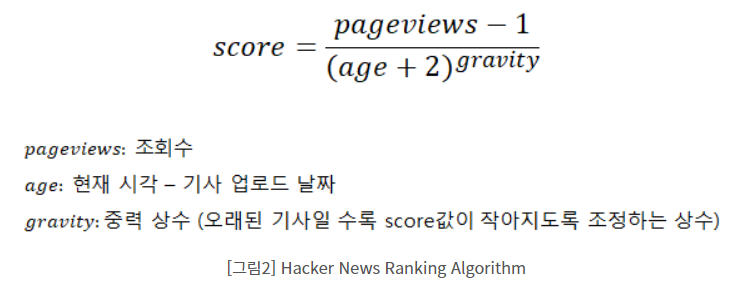

## Highly rated

In [ ]:
popular_df = movie_df1.copy()
popular_df = popular_df[['original_title', 'rating', 'popularity']]

print(popular_df.shape)
popular_df.head()

(44994, 3)


,original_title,rating,popularity
247,Ariel,3.0,3.860491
248,Ariel,5.0,3.860491
249,Ariel,3.0,3.860491
250,Ariel,5.0,3.860491
251,Ariel,2.0,3.860491


In [ ]:
popular_df['popularity'] = popular_df['popularity'].astype('float64')

In [ ]:
popular_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44994 entries, 247 to 99998
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_title  44994 non-null  object 
 1   rating          44994 non-null  float64
 2   popularity      44994 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
# # 높은 평점 추천 수식 정의
# def GetRating(positiveVotes, negativeVotes, popular, standard_score=0.5): 
#     totalVotes = positiveVotes + negativeVotes 
#     average = positiveVotes/totalVotes 
#     pop = popular * 0.1 
#     score = average - ( average - standard_score )*2**(-np.log10(totalVotes + 1))
#     return score * 100 + pop

In [ ]:
# 높은 평점 추천 수식 정의
def GetRating(positiveVotes, negativeVotes, nolmalized, standard_score=0.5): 
    totalVotes = positiveVotes + negativeVotes 
    average = positiveVotes/totalVotes 
    score = average - ( average - standard_score )*2**(-np.log10(totalVotes + 1))
    return score * 0.8 + nolmalized * 0.2

### score 생성

In [ ]:
df_score_max = popular_df.groupby(['original_title','popularity']).agg({'rating':'max'}).reset_index()
df_score_max.rename(columns={'rating':'score_max'}, inplace=True)

df_score_max.head()

,original_title,popularity,score_max
0,!Women Art Revolution,0.077485,3.5
1,'Gator Bait,0.908897,0.5
2,'Twas the Night Before Christmas,1.353059,4.5
3,...Più forte ragazzi!,6.100067,5.0
4,00 Schneider - Jagd auf Nihil Baxter,1.931299,4.5


In [ ]:
df_score_min = popular_df.groupby(['original_title','popularity']).agg({'rating':'min'}).reset_index()
df_score_min.rename(columns={'rating':'score_min'}, inplace=True)

df_score_min.head()

,original_title,popularity,score_min
0,!Women Art Revolution,0.077485,3.0
1,'Gator Bait,0.908897,0.5
2,'Twas the Night Before Christmas,1.353059,3.5
3,...Più forte ragazzi!,6.100067,0.5
4,00 Schneider - Jagd auf Nihil Baxter,1.931299,3.5


In [ ]:
df_score = pd.merge(df_score_max, df_score_min, on=['original_title','popularity'], how='inner')

df_score.head()

,original_title,popularity,score_max,score_min
0,!Women Art Revolution,0.077485,3.5,3.0
1,'Gator Bait,0.908897,0.5,0.5
2,'Twas the Night Before Christmas,1.353059,4.5,3.5
3,...Più forte ragazzi!,6.100067,5.0,0.5
4,00 Schneider - Jagd auf Nihil Baxter,1.931299,4.5,3.5


In [ ]:
df = df_score['popularity']
df_score['pop_normalized'] = (df - df.min()) / (df.max() - df.min())
df_score.head()

,original_title,popularity,score_max,score_min,pop_normalized
0,!Women Art Revolution,0.077485,3.5,3.0,0.000550
1,'Gator Bait,0.908897,0.5,0.5,0.006448
2,'Twas the Night Before Christmas,1.353059,4.5,3.5,0.009600
3,...Più forte ragazzi!,6.100067,5.0,0.5,0.043278
4,00 Schneider - Jagd auf Nihil Baxter,1.931299,4.5,3.5,0.013702


In [ ]:
df_score['score'] = df_score.apply(lambda row: GetRating(row['score_max'], row['score_min'], row['pop_normalized']), axis=1)

df_score.head()

,original_title,popularity,score_max,score_min,pop_normalized,score
0,!Women Art Revolution,0.077485,3.5,3.0,0.000550,0.414103
1,'Gator Bait,0.908897,0.5,0.5,0.006448,0.401290
2,'Twas the Night Before Christmas,1.353059,4.5,3.5,0.009600,0.426114
3,...Più forte ragazzi!,6.100067,5.0,0.5,0.043278,0.549635
4,00 Schneider - Jagd auf Nihil Baxter,1.931299,4.5,3.5,0.013702,0.426935


### Top 5 영화 추천

In [ ]:
no_ranking = 5 # 추천 수량 

popular_movie = df_score.sort_values(by=['score'], ascending=False)[:no_ranking]
popular_movie

,original_title,popularity,score_max,score_min,pop_normalized,score
1714,Pulp Fiction,140.950236,5.0,2.0,1.000000,0.679759
2113,The Dark Knight,123.167259,4.5,2.0,0.873835,0.644732
1224,La vita è bella,39.394970,5.0,0.5,0.279496,0.596878
314,Blade Runner,96.272374,4.0,2.0,0.683024,0.595715
1671,Pirates of the Caribbean: The Curse of the Bla...,47.326665,5.0,1.0,0.335769,0.585374


- score가 ranking 1 부터 10이상까지 동일하여 5개의 영화를 추천해주는 것이 사실상 의미가 없게 느껴짐
- 그래서 원데이터로부터 popularity값을 가지고와 추가반영
- 인기도의 경우 값이 워낙 다양하여 조금만 반영해도 평점의 순위를 뒤바꿈
- 평점은 낮은데 인기도가 높아 인기도 * 0.1이상만 반영해도 치고올라옴
- 평점과 인기도 둘 다 0과 1사이의 값으로 정규화 후 각각 0.8, 0.2 만큼 반영하여 더해줌 (이게 맞는지는 의문)
- Most popular에서 popularity 데이터와 날짜 기준 데이터를 통해 최신 영화중 인기 많았던 것으로 추천을해도 괜찮을 것 같음

# Contents Based Filtering

# Neural Collaborative Filtering

# 추천

In [ ]:
movie_df1['userId'] == 6000

247      False
248      False
249      False
250      False
251      False
         ...  
99858    False
99911    False
99974    False
99975    False
99998    False
Name: userId, Length: 44994, dtype: bool

In [ ]:
(movie_df1['userId'] == 33).value_counts()[0] != 44994

True

In [ ]:
# # ID 값 input으로 넣기
# Id = int(input("사용자 ID를 입력하세요."))

# if (movie_df1['userId'] == Id).value_counts()[1] != 44994:
#     print("아직 추천 못함")
# else:
#     print(popular_movie)

사용자 ID를 입력하세요.6000


IndexError: ignored